In [1]:
import numpy as np
import pandas as pd

import os
print(os.listdir("../input"))

['cell_images']


In [2]:
import tensorflow as tf
tf.enable_eager_execution()
is_correct_version = '1.13.' in tf.__version__
assert is_correct_version , "Wrong Tensorflow Version [{}]".format(tf.__version__)

tf.VERSION
is_eager_enabled = tf.executing_eagerly()
assert is_eager_enabled, "Eager mode not activated"

In [3]:
import pathlib
data_root = pathlib.Path("../input/cell_images/cell_images")
print(data_root)
for item in data_root.iterdir():
  print(item)

../input/cell_images/cell_images
../input/cell_images/cell_images/Uninfected
../input/cell_images/cell_images/Parasitized


In [4]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths if os.path.splitext(str(path))[1] == '.png']
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

27558

In [5]:
import os
for file_path in all_image_paths:
    filename, file_extension = os.path.splitext(file_path)
    if file_extension != '.png':
        print('this file : %s',filename)

In [6]:
all_image_paths[:10]

['../input/cell_images/cell_images/Uninfected/C205ThinF_IMG_20151106_151514_cell_203.png',
 '../input/cell_images/cell_images/Uninfected/C54P15thinF_IMG_20150728_102017_cell_11.png',
 '../input/cell_images/cell_images/Uninfected/C144P105ThinF_IMG_20151015_163432_cell_120.png',
 '../input/cell_images/cell_images/Parasitized/C132P93ThinF_IMG_20151004_152045_cell_118.png',
 '../input/cell_images/cell_images/Parasitized/C50P11thinF_IMG_20150724_114951_cell_148.png',
 '../input/cell_images/cell_images/Uninfected/C163P124ThinF_IMG_20151116_111147_cell_208.png',
 '../input/cell_images/cell_images/Uninfected/C82P43ThinF_IMG_20150817_124418_cell_98.png',
 '../input/cell_images/cell_images/Uninfected/C114P75ThinF_IMG_20150930_150833_cell_63.png',
 '../input/cell_images/cell_images/Parasitized/C101P62ThinF_IMG_20150918_151239_cell_88.png',
 '../input/cell_images/cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_134830_cell_69.png']

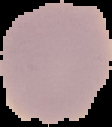

C78P39ThinF_IMG_20150606_103630_cell_37


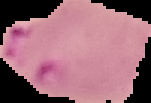

C99P60ThinF_IMG_20150918_141314_cell_129


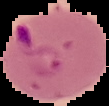

C132P93ThinF_IMG_20151004_152642_cell_6


In [7]:
import IPython.display as display

def caption_image(image_path):
    return image_path.split('/')[-1].split('.')[0]
    
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))

In [8]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Parasitized', 'Uninfected']

In [9]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Parasitized': 0, 'Uninfected': 1}

In [10]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 1, 1, 0, 0, 1, 1, 1, 0, 0]


In [11]:
img_path = all_image_paths[3]
img_path

'../input/cell_images/cell_images/Parasitized/C132P93ThinF_IMG_20151004_152045_cell_118.png'

In [12]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00v\x...


In [13]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(136, 118, 3)
<dtype: 'uint8'>


In [14]:
img_final = tf.image.resize_images(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
0.8968546


In [15]:
def preprocess_image(image):
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize_images(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

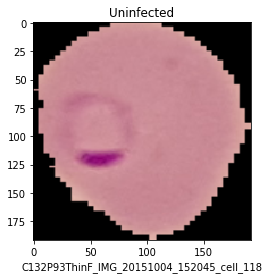

In [16]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

After inspecting the images, let's create the dataset iterator to use the dataset in the neural network.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
trainset_size = len(all_image_paths) * 70 // 100
print(trainset_size)
testset_size = len(all_image_paths) - trainset_size
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths[:trainset_size])
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

19290
shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [18]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Colocations handled automatically by placer.


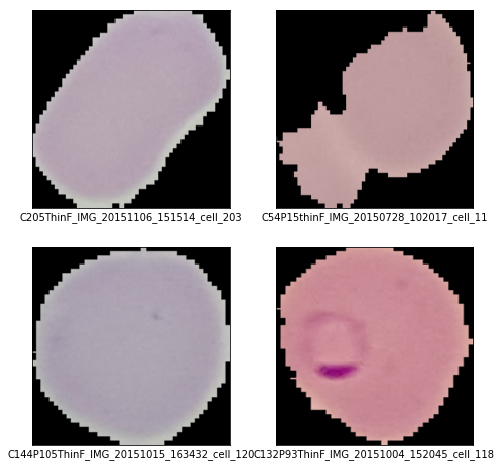

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))

In [20]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels[:trainset_size], tf.int64))

In [21]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

Uninfected
Uninfected
Uninfected
Parasitized
Parasitized
Uninfected
Uninfected
Uninfected
Parasitized
Parasitized


In [22]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print(image_label_ds)

image shape:  (192, 192, 3)
label shape:  ()
types:  (tf.float32, tf.int64)
<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [23]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths[:trainset_size], all_image_labels[:trainset_size]))

# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [24]:
BATCH_SIZE = 40


ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [25]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [26]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)
keras_ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [27]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [28]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 0s 0us/step


In [29]:
help(tf.keras.applications.mobilenet_v2.preprocess_input)

Help on function wrapper in module tensorflow.python.keras.applications:

wrapper(*args, **kwargs)



In [30]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(40, 6, 6, 1280)


In [31]:

model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), input_shape=(192, 192, 3), activation=tf.nn.relu),     


      tf.keras.layers.MaxPool2D(pool_size=(2,2)), 

      tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), input_shape=(86, 86, 3), activation=tf.nn.relu),

      tf.keras.layers.MaxPool2D(pool_size=(2,2)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(43, activation=tf.nn.relu),
      tf.keras.layers.Dense(len(label_names), activation=tf.nn.softmax)
  ])

In [32]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.4593085
max logit: 0.5406915

Shape: (40, 2)


In [33]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [34]:
len(model.trainable_variables) 

8

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 24)      672       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 36)        7812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 36)        0         
_________________________________________________________________
flatten (Flatten)            (None, 76176)             0         
_________________________________________________________________
dense (Dense)                (None, 43)                3275611   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 88        
Total para

In [36]:
steps_per_epoch=tf.ceil(trainset_size/BATCH_SIZE).numpy()
steps_per_epoch

483.0

In [37]:
model.fit(ds, epochs=5, steps_per_epoch=10)

Epoch 1/5
10/10 [==============================] - 79s 8s/step - loss: 1.4680 - acc: 0.5350
Epoch 2/5
10/10 [==============================] - 14s 1s/step - loss: 0.6939 - acc: 0.5250
Epoch 3/5
10/10 [==============================] - 14s 1s/step - loss: 0.6896 - acc: 0.5350
Epoch 4/5
10/10 [==============================] - 14s 1s/step - loss: 0.6780 - acc: 0.6075
Epoch 5/5
10/10 [==============================] - 14s 1s/step - loss: 0.6721 - acc: 0.6050


In [38]:
ds_test = tf.data.Dataset.from_tensor_slices((all_image_paths[trainset_size:], all_image_labels[trainset_size:]))

# The tuples are unpacked into the positional arguments of the mapped function 

image_label_testds = ds_test.map(load_and_preprocess_from_path_label)
image_label_testds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [39]:
def plot_value_array(predictions_array, true_label):
  #predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
    
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

[0.46770656 0.53229344]
0
[0.60319966 0.3968003 ]
1
[0.4154209 0.5845791]
1
[0.4173107 0.5826893]
0
[0.20879918 0.79120076]
1
[0.22962281 0.7703772 ]
1
[0.4893319  0.51066804]
0
[0.45755127 0.54244876]
0
[0.3823224 0.6176776]
1
[0.5260693 0.4739307]
1
[0.49139675 0.5086033 ]
0
[0.4208281 0.5791719]
0
[0.3563564  0.64364356]
1
[0.29820874 0.7017913 ]
1
[0.33056208 0.6694379 ]
1


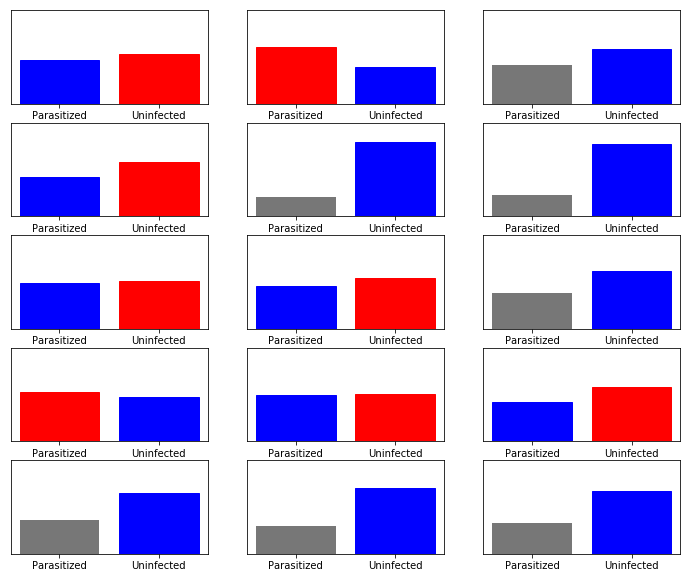

In [40]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
fig = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
fig.tight_layout()

for i in range(num_images):
    test_ds = load_and_preprocess_image(all_image_paths[trainset_size + i])

    test_ds
    ds = np.expand_dims(test_ds,0)

    predictions_single = model.predict(ds, steps=10)

    print(predictions_single[0])
    print(all_image_labels[trainset_size + i])
    plt.subplot(num_rows, num_cols,i+1)

    plot_value_array(predictions_single[0], all_image_labels[trainset_size + i])
    _ = plt.xticks(range(2), label_names)
    
plt.show()